In [9]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tensorflow.keras.datasets import mnist


from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import plotly.tools as tls
from sklearn.preprocessing import LabelBinarizer

# Pytorch

In [63]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("Train data: \n Mean:", X_train.flatten().mean(), "\n Std:", X_train.flatten().std())

transforms = torchvision.transforms.Normalize([33.32],[78.56])

BATCH_SIZE = 32

torch_X_train = torch.from_numpy(X_train).type(torch.FloatTensor)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
torch_X_test = torch.from_numpy(X_test).type(torch.FloatTensor)
torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor) # data type is long

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train,transforms)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test,transforms)
# train = torch.utils.data.TensorDataset(torch_X_train,torch_X_train)
# test = torch.utils.data.TensorDataset(torch_X_test,torch_X_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)

Train data: 
 Mean: 33.318421449829934 
 Std: 78.56748998339798


AttributeError: 'Normalize' object has no attribute 'size'

In [5]:
torch_X_train.dtype

torch.float32

In [25]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512,128)
        self.fc3 = nn.Linear(128,32)
        self.fc4 = nn.Linear(32,3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(3,32)
        self.fc2 = nn.Linear(32,128)
        self.fc3 = nn.Linear(128,512)
        self.fc4 = nn.Linear(512,784)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        return x

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.enc = Encoder()
        self.dec = Decoder()

    def forward(self, x):
        return self.dec(self.enc(x))

In [46]:
autoencoder = AutoEncoder()

criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [47]:
# torch.set_default_tensor_type('torch.LongTensor')
losses = []
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader),total=len(train_loader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, _ = data
        inputs = inputs.reshape(-1,28*28)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        if i % 200 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, loss.item()))
            
            losses.append(loss.item())
    
    
print('Finished Training')

[1,     1] loss: 6934.779
[1,   201] loss: 4424.367
[1,   401] loss: 3760.792
[1,   601] loss: 4252.947
[1,   801] loss: 3552.832
[1,  1001] loss: 3639.010
[1,  1201] loss: 3580.341
[1,  1401] loss: 3305.910
[1,  1601] loss: 3943.607
[1,  1801] loss: 3163.140



[2,     1] loss: 3308.258
[2,   201] loss: 3404.175
[2,   401] loss: 3233.177
[2,   601] loss: 3747.644
[2,   801] loss: 3256.865
[2,  1001] loss: 3526.850
[2,  1201] loss: 3324.633
[2,  1401] loss: 3090.034
[2,  1601] loss: 3615.613
[2,  1801] loss: 3057.742

Finished Training


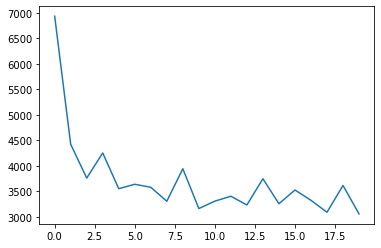

In [48]:
plt.plot(losses)

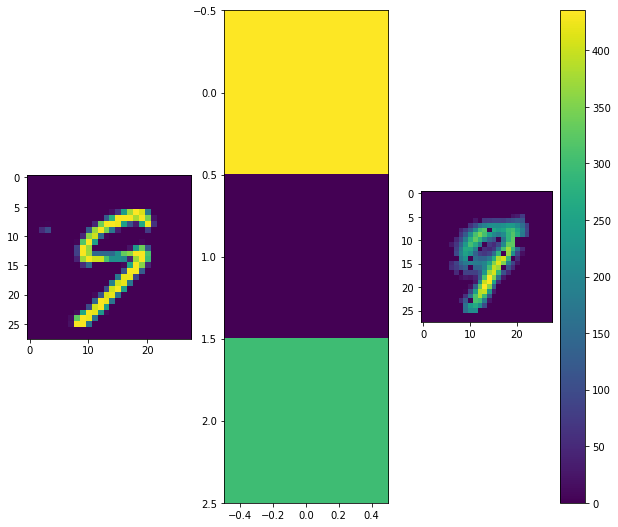

In [54]:
i=1

latent=autoencoder.enc(inputs[i])
output=autoencoder(inputs[i])

fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(inputs[i].reshape(28,28))
l = ax[1].imshow(latent.detach().numpy().reshape(3,1))
fig.colorbar(l)
ax[2].imshow(output.detach().numpy().reshape(28,28))

## Latent Space

In [50]:
output = autoencoder.enc(torch_X_train.reshape(-1,28*28))
predicted = output.detach().numpy()

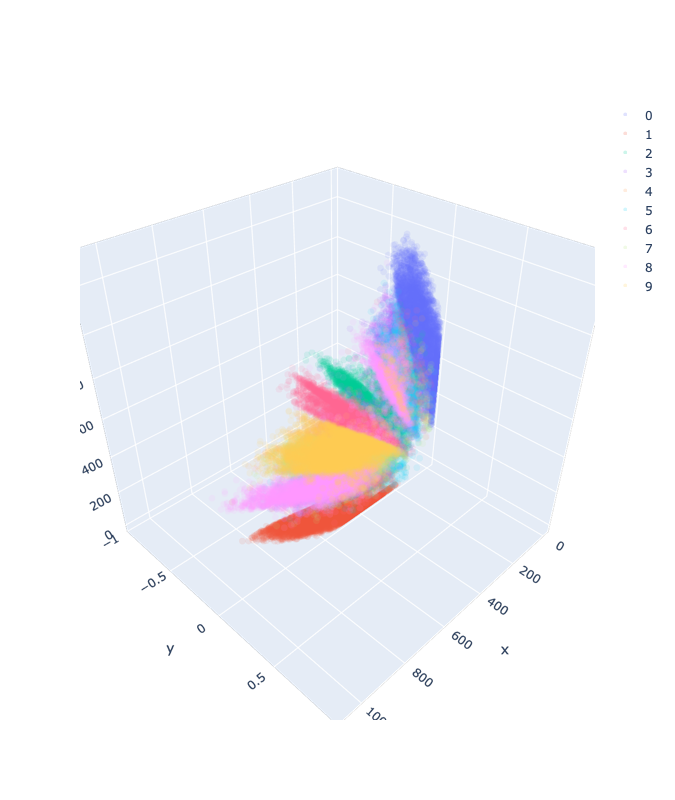

In [51]:
import plotly.graph_objects as go
import numpy as np

colors = plt.cm.winter(np.linspace(0,1,10))
color = 'rgb({0:3.0f}, {1:3.0f}, {2:3.0f})'.format(*colors[0]*255)

fig = go.Figure(data=[go.Scatter3d(x=predicted[y_train==i,0], y=predicted[y_train==i,1], z=predicted[y_train==i,2], 
                                   marker=dict(size=4, opacity=0.1),
                                   mode='markers', name =f'{i}') for i in range(10)])

fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.update_layout(showlegend=True)
fig.show()